In [1]:
import joblib
import json
import numpy as np
import base64
import cv2
from matplotlib import pyplot as plt

In [2]:
def bgremove1(myimage):
 
    # Blur to image to reduce noise
    myimage = cv2.GaussianBlur(myimage,(5,5), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv2.threshold(myimage_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv2.threshold(myimage_grey,0,255,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background
    return finalimage
    
import pywt

def w2d(img, mode='haar', level=1):
    
    # imArray = bgremove1(img)
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [3]:
__class_name_to_number = {}
__class_number_to_name = {}

__model = None


In [4]:
def class_number_to_name(class_num):
    return __class_number_to_name[class_num]

def load_saved_artifacts():
    print("loading saved artifacts...start")
    global __class_name_to_number
    global __class_number_to_name

    with open("./artifacts/class_dictionary.json", "r") as f:
        __class_name_to_number = json.load(f)
        __class_number_to_name = {v:k for k,v in __class_name_to_number.items()}

    global __model
    if __model is None:
        with open('./artifacts/saved_model.pkl', 'rb') as f:
            __model = joblib.load(f)
    print("loading saved artifacts...done")

# def get_cv2_image_from_base64_string(b64str):
#     '''
#     credit: https://stackoverflow.com/questions/33754935/read-a-base-64-encoded-image-from-memory-using-opencv-python-library
#     :param uri:
#     :return:
#     '''
#     encoded_data = b64str.split(',')[1]
#     nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
#     img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#     return img
load_saved_artifacts()

loading saved artifacts...start
loading saved artifacts...done


In [5]:
def classify_image(image_base64_data=None, file_path=None):

    # imgs = get_cropped_image_if_2_eyes(file_path, image_base64_data)
    img = cv2.imread(file_path)
    
    result = []
    
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img, 'db10',2)
    
    scalled_img_har = cv2.resize(img_har, (32, 32))
    plt.imshow(scalled_img_har)
    combined_img = np.vstack((scalled_raw_img.reshape(32 * 32 * 3, 1), scalled_img_har.reshape(32 * 32, 1)))
   
    len_image_array = 32*32*3 + 32*32

    final = combined_img.reshape(1,len_image_array).astype(float)
    result=class_number_to_name(__model.predict(final)[0])

    return result

## Try out images by path here

B


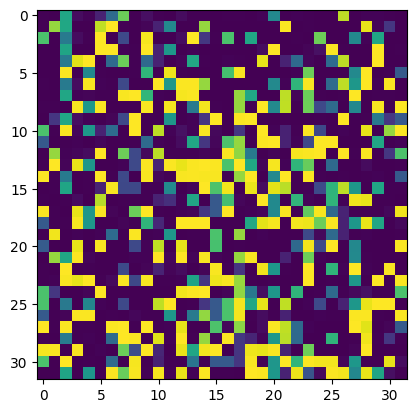

In [6]:
print(classify_image(None, "./trainingData/B/bTest3.jpg"))
# print(classify_image(None, "./test_images/virat3.jpg")) # Inconsistent result could be due to https://github.com/scikit-learn/scikit-learn/issues/13211